In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

import tensorflow as tf

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

#import aparent.visualization as vis

#from aparent_predictor import *


Using TensorFlow backend.


In [2]:
#Store variant prediction dataframe

variant_df = pd.read_csv('aparent_resnet_variant_predictions_polyadb_no_sequences_no_cutoff.csv', sep='\t')


In [3]:
#Load APADB Data and filter on targeted genes

#genes = ['RUNX1', 'CEBPA', 'GATA2', 'ANKRD26', 'DDX41', 'ETV6', 'PTEN', 'BRCA1', 'BRCA2', 'TP53', 'APC', 'ATM', 'PALB2', 'MSH2', 'MLH1', 'MSH6', 'PMS2', 'MUTYH']

polyadb_df = pd.read_csv('polyadb_processed.csv', sep=',')

#polyadb_df = polyadb_df.loc[polyadb_df['gene'].isin(genes)].reset_index(drop=True).copy()
polyadb_df = polyadb_df.loc[((~polyadb_df['gene'].isnull()) & (polyadb_df['gene'] != 'na')) & (polyadb_df['pas'] != -1)].reset_index(drop=True).copy()

print('len(polyadb_df) = ' + str(len(polyadb_df)))


len(polyadb_df) = 175451


In [4]:
#Process PolyaDB data

polyadb_df_minus = polyadb_df.query("strand == '-'").copy().reset_index(drop=True)
polyadb_df_plus = polyadb_df.query("strand == '+'").copy().reset_index(drop=True)

polyadb_df_minus = polyadb_df_minus.sort_values(by='pas_pos', ascending=False).copy().reset_index(drop=True)
polyadb_df_plus = polyadb_df_plus.sort_values(by='pas_pos', ascending=True).copy().reset_index(drop=True)

new_gene_id_list_plus = []
sitenum_list_plus = []
gene_id_dict = {}
for _, row in polyadb_df_plus.iterrows() :

    gene = row['gene']

    if gene not in gene_id_dict :
        gene_id_dict[gene] = 0

    gene_id_dict[gene] += 1

    new_gene_id_list_plus.append(gene + "." + str(gene_id_dict[gene]))
    sitenum_list_plus.append(gene_id_dict[gene])

polyadb_df_plus['gene_id'] = new_gene_id_list_plus
polyadb_df_plus['sitenum'] = sitenum_list_plus

new_gene_id_list_minus = []
sitenum_list_minus = []
gene_id_dict = {}
for _, row in polyadb_df_minus.iterrows() :

    gene = row['gene']

    if gene not in gene_id_dict :
        gene_id_dict[gene] = 0

    gene_id_dict[gene] += 1

    new_gene_id_list_minus.append(gene + "." + str(gene_id_dict[gene]))
    sitenum_list_minus.append(gene_id_dict[gene])

polyadb_df_minus['gene_id'] = new_gene_id_list_minus
polyadb_df_minus['sitenum'] = sitenum_list_minus

polyadb_df = pd.concat([polyadb_df_plus, polyadb_df_minus])

polyadb_df = polyadb_df.sort_values(by=['gene', 'sitenum'], ascending=True).reset_index(drop=True).copy()

In [5]:
#Get variant positions in hg38 coordinates

polyadb_bed_hg19 = pd.read_csv("polyadb_coordinates_utr3_hg19.bed", sep='\t', header=None, names=['chrom', 'pas_pos_hg19', 'end', 'gene', 'gene_id', 'strand'])
polyadb_bed_hg38 = pd.read_csv("polyadb_coordinates_utr3_hg38.bed", sep='\t', header=None, names=['chrom', 'pas_pos_hg38', 'end', 'gene', 'gene_id', 'strand'])

polyadb_bed_hg38 = polyadb_bed_hg38.join(polyadb_bed_hg19[['gene_id', 'pas_pos_hg19']].set_index('gene_id'), on='gene_id', how='inner').copy().reset_index(drop=True)

polyadb_bed_hg38['padb_join_id'] = polyadb_bed_hg38['chrom'] + "_" + polyadb_bed_hg38['pas_pos_hg19'].astype(str) + "_" + polyadb_bed_hg38['gene']
polyadb_df['padb_join_id'] = polyadb_df['chrom'] + "_" + polyadb_df['pas_pos'].astype(str) + "_" + polyadb_df['gene']

polyadb_df = polyadb_df.join(polyadb_bed_hg38[['padb_join_id', 'pas_pos_hg38']].set_index("padb_join_id"), on='padb_join_id', how='inner').copy().reset_index(drop=True)

polyadb_df = polyadb_df.query("site_type == '3_most_exon'")

polyadb_df = polyadb_df.drop_duplicates(subset=['gene_id'], keep='first').copy().reset_index(drop=True)

variant_df = variant_df.join(polyadb_df[['gene_id', 'pas_pos', 'pas_pos_hg38', 'sitenum', 'num_sites', 'pas']].set_index("gene_id"), on='gene_id', how='inner').copy().reset_index(drop=True)

variant_df['var_position_hg38'] = variant_df['var_position'] - variant_df['pas_pos'] + variant_df['pas_pos_hg38']


In [6]:

variant_df_gnomad = pd.read_csv("aparent_resnet_variant_predictions_polyadb_no_sequences_gnomad_no_cutoff_shifted.csv", sep='\t')

polyadb_df = polyadb_df.drop_duplicates(subset=['gene_id'], keep='first').copy().reset_index(drop=True)
variant_df_gnomad = variant_df_gnomad.join(polyadb_df[['gene_id', 'pas']].set_index("gene_id"), on='gene_id', how='inner').copy().reset_index(drop=True)


In [7]:

variant_df_gnomad['rel_var_position'] = -1
variant_df_gnomad.loc[variant_df_gnomad['strand'] == '+', 'rel_var_position'] = variant_df_gnomad['var_position'] - (variant_df_gnomad['pas_pos'] - 70 + 1)
variant_df_gnomad.loc[variant_df_gnomad['strand'] == '-', 'rel_var_position'] = ((variant_df_gnomad['pas_pos'] - (205 - 70)) + 205) - variant_df_gnomad['var_position']


In [8]:

variant_df['rel_var_position'] = -1
variant_df.loc[variant_df['strand'] == '+', 'rel_var_position'] = variant_df['var_position'] - (variant_df['pas_pos'] - 70 + 1)
variant_df.loc[variant_df['strand'] == '-', 'rel_var_position'] = ((variant_df['pas_pos'] - (205 - 70)) + 205) - variant_df['var_position']


In [9]:

variant_df_gnomad['alt_usage'] = 1. / (1. + 1. / ((np.clip(variant_df_gnomad['native_usage'], 1e-7, 1. - 1e-7) / (1. - np.clip(variant_df_gnomad['native_usage'], 1e-7, 1. - 1e-7))) * np.exp(variant_df_gnomad['delta_logodds_0_205'])))
variant_df_gnomad['delta_usage'] = variant_df_gnomad['alt_usage'] - variant_df_gnomad['native_usage']


In [10]:

variant_df['alt_usage'] = 1. / (1. + 1. / ((np.clip(variant_df['native_usage'], 1e-7, 1. - 1e-7) / (1. - np.clip(variant_df['native_usage'], 1e-7, 1. - 1e-7))) * np.exp(variant_df['delta_logodds_0_205'])))
variant_df['delta_usage'] = variant_df['alt_usage'] - variant_df['native_usage']


In [11]:

variant_df_gnomad['alt_usage_77_127'] = 1. / (1. + 1. / ((np.clip(variant_df_gnomad['native_usage'], 1e-7, 1. - 1e-7) / (1. - np.clip(variant_df_gnomad['native_usage'], 1e-7, 1. - 1e-7))) * np.exp(variant_df_gnomad['delta_logodds_77_127'])))
variant_df_gnomad['delta_usage_77_127'] = variant_df_gnomad['alt_usage_77_127'] - variant_df_gnomad['native_usage']


In [12]:

variant_df['alt_usage_77_127'] = 1. / (1. + 1. / ((np.clip(variant_df['native_usage'], 1e-7, 1. - 1e-7) / (1. - np.clip(variant_df['native_usage'], 1e-7, 1. - 1e-7))) * np.exp(variant_df['delta_logodds_77_127'])))
variant_df['delta_usage_77_127'] = variant_df['alt_usage_77_127'] - variant_df['native_usage']


In [13]:
#Load ASD cohort data

asd_df = pd.read_csv("asd_cohort_de_novos.csv", sep=',')

asd_df['Chrom'] = asd_df['Chr'].astype(str)

asd_df['join_id'] = asd_df['Chrom'] + "_" + asd_df['Pos'].astype(str) + "_" + asd_df['Alt'].astype(str)
variant_df['join_id'] = variant_df['chrom'] + "_" + variant_df['var_position_hg38'].astype(str) + "_" + variant_df['var_nucleotide'].astype(str)

asd_df = asd_df.join(variant_df.set_index("join_id"), on='join_id', how='inner').copy().reset_index(drop=True)
asd_df = asd_df.join(variant_df_gnomad[['gnomad_join_id', 'AF', 'AC', 'AN']].set_index("gnomad_join_id"), on='join_id', how='left').copy().reset_index(drop=True)


In [14]:
#Compute aggregate-level PAS statistics

singleton_agg_df = variant_df_gnomad.query("AC == 1").groupby("gene_id").agg({
    "delta_logodds_77_127" : ["min", "max", "median", "count"],
    "delta_logodds_0_205" : ["min", "max", "median", "count"],
    "delta_usage_77_127" : ["min", "max", "median", "count"],
    "delta_usage" : ["min", "max", "median", "count"],
}).copy().reset_index()

singleton_agg_df.columns = ['_'.join(col).strip() + "_singleton" for col in singleton_agg_df.columns.values]

af_0_0001_agg_df = variant_df_gnomad.query("(AC > 1) and AF >= 0.0001").groupby("gene_id").agg({
    "delta_logodds_77_127" : ["min", "max", "median", "count"],
    "delta_logodds_0_205" : ["min", "max", "median", "count"],
    "delta_usage_77_127" : ["min", "max", "median", "count"],
    "delta_usage" : ["min", "max", "median", "count"],
}).copy().reset_index()

af_0_0001_agg_df.columns = ['_'.join(col).strip() + "_0_0001" for col in af_0_0001_agg_df.columns.values]

af_0_001_agg_df = variant_df_gnomad.query("(AC > 1) and AF >= 0.001").groupby("gene_id").agg({
    "delta_logodds_77_127" : ["min", "max", "median", "count"],
    "delta_logodds_0_205" : ["min", "max", "median", "count"],
    "delta_usage_77_127" : ["min", "max", "median", "count"],
    "delta_usage" : ["min", "max", "median", "count"],
}).copy().reset_index()

af_0_001_agg_df.columns = ['_'.join(col).strip() + "_0_001" for col in af_0_001_agg_df.columns.values]

af_0_01_agg_df = variant_df_gnomad.query("(AC > 1) and AF >= 0.01").groupby("gene_id").agg({
    "delta_logodds_77_127" : ["min", "max", "median", "count"],
    "delta_logodds_0_205" : ["min", "max", "median", "count"],
    "delta_usage_77_127" : ["min", "max", "median", "count"],
    "delta_usage" : ["min", "max", "median", "count"],
}).copy().reset_index()

af_0_01_agg_df.columns = ['_'.join(col).strip() + "_0_01" for col in af_0_01_agg_df.columns.values]

af_0_1_agg_df = variant_df_gnomad.query("(AC > 1) and AF >= 0.1").groupby("gene_id").agg({
    "delta_logodds_77_127" : ["min", "max", "median", "count"],
    "delta_logodds_0_205" : ["min", "max", "median", "count"],
    "delta_usage_77_127" : ["min", "max", "median", "count"],
    "delta_usage" : ["min", "max", "median", "count"],
}).copy().reset_index()

af_0_1_agg_df.columns = ['_'.join(col).strip() + "_0_1" for col in af_0_1_agg_df.columns.values]

asd_df = asd_df.join(singleton_agg_df.set_index('gene_id__singleton'), on='gene_id', how='left').copy().reset_index(drop=True)
asd_df = asd_df.join(af_0_0001_agg_df.set_index('gene_id__0_0001'), on='gene_id', how='left').copy().reset_index(drop=True)
asd_df = asd_df.join(af_0_001_agg_df.set_index('gene_id__0_001'), on='gene_id', how='left').copy().reset_index(drop=True)
asd_df = asd_df.join(af_0_01_agg_df.set_index('gene_id__0_01'), on='gene_id', how='left').copy().reset_index(drop=True)
asd_df = asd_df.join(af_0_1_agg_df.set_index('gene_id__0_1'), on='gene_id', how='left').copy().reset_index(drop=True)


In [15]:

#asd_df_copy = asd_df.copy()


In [16]:

asd_df = asd_df_copy.copy()


In [17]:

asd_df = asd_df.loc[asd_df['Consequence'].isin([
    '3_prime_UTR_variant',
    'intron_variant&non_coding_transcript_variant',
    'non_coding_transcript_exon_variant',
])].copy()


In [18]:

asd_df['pas'] = -1. * asd_df['pas']
asd_df['abs_delta_usage'] = np.abs(asd_df['delta_usage'])
asd_df = asd_df.sort_values(by=["pas", 'abs_delta_usage'], ascending=False).drop_duplicates(subset=['join_id', 'gene', 'Pheno'], keep='first').copy().reset_index(drop=True)


In [19]:
#Load APARENT Resnet

#model_name = 'aparent_all_libs_resnet_no_clinvar_wt_ep_5'
#save_dir = os.path.join(os.getcwd(), './')

model_name = 'aparent_all_libs_resnet_no_clinvar_wt_ep_5_var_batch_size'
save_dir = os.path.join(os.getcwd(), '../../autoscrambler/analysis/apa/saved_models')

model_path = os.path.join(save_dir, model_name + '.h5')

aparent_model = load_model(model_path)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [20]:
class OneHotEncoder :
    def __init__(self, seq_length=100, default_fill_value=0) :
        self.seq_length = seq_length
        self.default_fill_value = default_fill_value
        self.encode_map = {
            'A' : 0,
            'C' : 1,
            'G' : 2,
            'T' : 3
        }
        self.decode_map = {
            0 : 'A',
            1 : 'C',
            2 : 'G',
            3 : 'T',
            -1 : 'X'
        }

    def encode(self, seq) :
        one_hot = np.zeros((self.seq_length, 4))
        self.encode_inplace(seq, one_hot)

        return one_hot

    def encode_inplace(self, seq, encoding) :
        for pos, nt in enumerate(list(seq)) :
            if nt in self.encode_map :
                encoding[pos, self.encode_map[nt]] = 1
            elif self.default_fill_value != 0 :
                encoding[pos, :] = self.default_fill_value

    def __call__(self, seq) :
        return self.encode(seq)

def get_aparent_encoder(lib_bias=11) :
    onehot_encoder = OneHotEncoder(205)

    def encode_for_aparent(sequences) :
        one_hots = np.concatenate([onehot_encoder(sequence)[None, None, ...] for sequence in sequences], axis=0)

        fake_lib = np.zeros((len(sequences), 13))

        if lib_bias is not None :
            fake_lib[:, lib_bias] = 1.

        return [
            one_hots,
            fake_lib
        ]

    return encode_for_aparent


In [21]:
#Predict wildtype polyadb PAS scores

aparent_encoder = get_aparent_encoder()

ref_seqs = polyadb_df['wide_seq_ext'].str.slice(175-70, 175-70+205).values.tolist()

#Predict reference sequence with APARENT model
_, ref_cut_pred = aparent_model.predict(x=aparent_encoder(ref_seqs), batch_size=32, verbose=True)

ref_iso_pred_77_127 = np.clip(np.sum(ref_cut_pred[:, 77:127], axis=-1), 1e-7, 1. - 1e-7)
ref_iso_pred_0_205 = np.clip(np.sum(ref_cut_pred[:, 0:205], axis=-1), 1e-7, 1. - 1e-7)

logodds_77_127 = np.log(ref_iso_pred_77_127 / (1. - ref_iso_pred_77_127))
logodds_0_205 = np.log(ref_iso_pred_0_205 / (1. - ref_iso_pred_0_205))

polyadb_df['wt_logodds_77_127'] = logodds_77_127
polyadb_df['wt_logodds_0_205'] = logodds_0_205


100100/100100 [==============================] - 341s 3ms/step


In [22]:

dist_cutoff = 200.

polyadb_df_gene_id = polyadb_df.copy().set_index("gene_id")

max_upstream_scores = []
wildtype_scores = []
max_downstream_scores = []

i = 0
for _, row in asd_df.iterrows() :
    
    if i % 100 == 0 :
        print("Processing variant " + str(i))
    
    wildtype_score = polyadb_df_gene_id.loc[row['gene_id']]['wt_logodds_77_127']
    curr_pos = polyadb_df_gene_id.loc[row['gene_id']]['pas_pos_hg38']
    
    upstream_scores = np.array(polyadb_df.query("gene == '" + row['gene'] + "' and sitenum < " + str(row['sitenum']))['wt_logodds_77_127'].values)
    upstream_dists = np.abs(curr_pos - np.array(polyadb_df.query("gene == '" + row['gene'] + "' and sitenum < " + str(row['sitenum']))['pas_pos_hg38'].values))
    
    downstream_scores = np.array(polyadb_df.query("gene == '" + row['gene'] + "' and sitenum > " + str(row['sitenum']))['wt_logodds_77_127'].values)
    downstream_dists = np.abs(curr_pos - np.array(polyadb_df.query("gene == '" + row['gene'] + "' and sitenum > " + str(row['sitenum']))['pas_pos_hg38'].values))
    
    if upstream_scores[upstream_dists < dist_cutoff].shape[0] > 0 :
        max_upstream_scores.append(np.max(upstream_scores[upstream_dists < dist_cutoff]))
    else :
        max_upstream_scores.append(-10.)
    
    wildtype_scores.append(wildtype_score)
    
    if downstream_scores[downstream_dists < dist_cutoff].shape[0] > 0 :
        max_downstream_scores.append(np.max(downstream_scores[downstream_dists < dist_cutoff]))
    else :
        max_downstream_scores.append(-10.)
    
    i += 1


Processing variant 0
Processing variant 100
Processing variant 200
Processing variant 300
Processing variant 400
Processing variant 500


In [23]:

asd_df['upstream_score'] = max_upstream_scores
asd_df['wildtype_score'] = wildtype_scores
asd_df['downstream_score'] = max_downstream_scores


Wilcoxon statistic = -4.1923
P-value = 2.7611421739710795e-05
n1 / n2 = 104 / 110


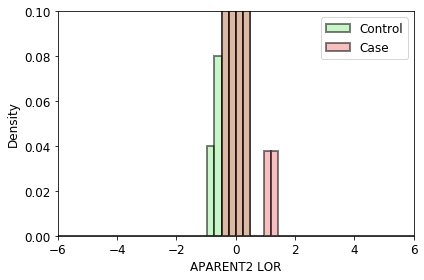

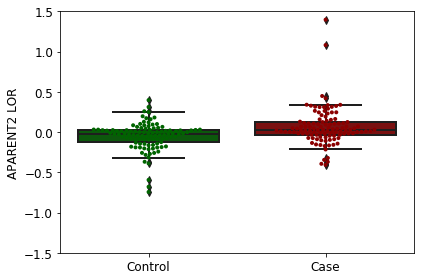

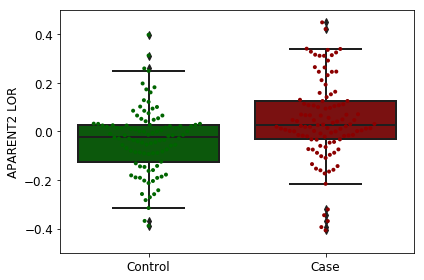

In [24]:
from scipy.stats import ttest_ind, ranksums

f = plt.figure(figsize=(6, 4))

af_cutoff_str = "0_0001"
delta_logodds_cutoff = np.abs(np.log(1.25))

filter_query = "((delta_logodds_0_205_max_" + af_cutoff_str + " != delta_logodds_0_205_max_" + af_cutoff_str + " or (delta_logodds_0_205 > delta_logodds_0_205_max_" + af_cutoff_str + " and delta_logodds_0_205_max_" + af_cutoff_str + " < " + str(delta_logodds_cutoff) + ")) or (delta_logodds_0_205_min_" + af_cutoff_str + " != delta_logodds_0_205_min_" + af_cutoff_str + " or (delta_logodds_0_205 < delta_logodds_0_205_min_" + af_cutoff_str + " and delta_logodds_0_205_min_" + af_cutoff_str + " > -" + str(delta_logodds_cutoff) + ")))"

asd_df_control = asd_df.query("Pheno == 'control' and downstream_score < -6. and " + filter_query).copy()
asd_df_case = asd_df.query("Pheno == 'case' and downstream_score < -6. and " + filter_query).copy()

x_control = asd_df_control['delta_logodds_0_205']
x_case = asd_df_case['delta_logodds_0_205']

x_thresh = 6.
x_min = -6.

x1 = x_control
x2 = x_case

s, p = ranksums(x1, x2)

print("Wilcoxon statistic = " + str(round(s, 4)))
print("P-value = " + str(p))
print("n1 / n2 = " + str(x1.shape[0]) + " / " + str(x2.shape[0]))

x1_hist, bin_edges = np.histogram(x1, range=(x_min, x_thresh), bins=50, density=True)
x2_hist, _ = np.histogram(x2, range=(x_min, x_thresh), bins=50, density=True)

bin_width = bin_edges[1] - bin_edges[0]

plt.bar(bin_edges[:-1] + bin_width/2., x1_hist, width=bin_width, color='lightgreen', alpha=0.5, linewidth=2, edgecolor='black', label='Control')
plt.bar(bin_edges[:-1] + bin_width/2., x2_hist, width=bin_width, color='lightcoral', alpha=0.5, linewidth=2, edgecolor='black', label='Case')

plt.xlim(x_min, x_thresh)
plt.ylim(0., 0.1)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("APARENT2 LOR", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig("apa_asd_LOR_vs_control_histo_lor_cutoff_stringent_v2.eps")
plt.savefig("apa_asd_LOR_vs_control_histo_lor_cutoff_stringent_v2.png", dpi=300, transparent=True)

plt.show()

import seaborn as sns

f = plt.figure(figsize=(6, 4))

sns.swarmplot(data=[
    x1,
    x2,
], s=4, palette=['darkgreen', 'darkred'])

sns.boxplot(data=[
    x1,
    x2,
], color='black', linewidth=2, palette=['darkgreen', 'darkred'])

plt.ylim(-1.5, 1.5)

plt.xticks([0, 1], ["Control", "Case"], fontsize=12)
plt.yticks(fontsize=12)

plt.ylabel("APARENT2 LOR", fontsize=12)

plt.tight_layout()

plt.savefig("apa_asd_LOR_vs_control_boxplot_cutoff_stringent_v2.eps")
plt.savefig("apa_asd_LOR_vs_control_boxplot_cutoff_stringent_v2.png", dpi=300, transparent=True)

plt.show()


f = plt.figure(figsize=(6, 4))

sns.swarmplot(data=[
    x1,
    x2,
], s=4, palette=['darkgreen', 'darkred'])

sns.boxplot(data=[
    x1,
    x2,
], color='black', linewidth=2, palette=['darkgreen', 'darkred'])

plt.ylim(-0.5, 0.5)

plt.xticks([0, 1], ["Control", "Case"], fontsize=12)
plt.yticks(fontsize=12)

plt.ylabel("APARENT2 LOR", fontsize=12)

plt.tight_layout()

plt.savefig("apa_asd_LOR_vs_control_boxplot_cutoff_zoom_stringent_v2.eps")
plt.savefig("apa_asd_LOR_vs_control_boxplot_cutoff_zoom_stringent_v2.png", dpi=300, transparent=True)

plt.show()


In [25]:
from scipy.stats import fisher_exact

#Exact test - Centered-on PAS upregulation

gof_pas_table = np.zeros((2, 2))

af_cutoff_str = "0_0001"
delta_logodds_cutoff = np.abs(np.log(1.25))

filter_query = "((delta_logodds_77_127_max_" + af_cutoff_str + " != delta_logodds_77_127_max_" + af_cutoff_str + " or (delta_logodds_77_127 > delta_logodds_77_127_max_" + af_cutoff_str + " and delta_logodds_77_127_max_" + af_cutoff_str + " < " + str(delta_logodds_cutoff) + ")) or (delta_logodds_77_127_min_" + af_cutoff_str + " != delta_logodds_77_127_min_" + af_cutoff_str + " or (delta_logodds_77_127 < delta_logodds_77_127_min_" + af_cutoff_str + " and delta_logodds_77_127_min_" + af_cutoff_str + " > -" + str(delta_logodds_cutoff) + ")))"

gof_pas_table[0, 0] = len(asd_df.query("Pheno == 'control' and downstream_score < -6. and delta_logodds_77_127 <= 0 and " + filter_query))
gof_pas_table[0, 1] = len(asd_df.query("Pheno == 'control' and downstream_score < -6. and delta_logodds_77_127 > 0 and " + filter_query))

gof_pas_table[1, 0] = len(asd_df.query("Pheno == 'case' and downstream_score < -6. and delta_logodds_77_127 <= 0 and " + filter_query))
gof_pas_table[1, 1] = len(asd_df.query("Pheno == 'case' and downstream_score < -6. and delta_logodds_77_127 > 0 and " + filter_query))

oddsr, p = fisher_exact(gof_pas_table, alternative='greater')

print(str(gof_pas_table))

print("odds ratio = " + str(oddsr))
print("p = " + str(p))


[[65. 36.]
 [37. 62.]]
odds ratio = 3.0255255255255253
p = 0.00011014151275686751


In [26]:
from scipy.stats import fisher_exact

#Exact test - All-PAS upregulation

gof_pas_table = np.zeros((2, 2))

af_cutoff_str = "0_0001"
delta_logodds_cutoff = np.abs(np.log(1.25))

filter_query = "((delta_logodds_0_205_max_" + af_cutoff_str + " != delta_logodds_0_205_max_" + af_cutoff_str + " or (delta_logodds_0_205 > delta_logodds_0_205_max_" + af_cutoff_str + " and delta_logodds_0_205_max_" + af_cutoff_str + " < " + str(delta_logodds_cutoff) + ")) or (delta_logodds_0_205_min_" + af_cutoff_str + " != delta_logodds_0_205_min_" + af_cutoff_str + " or (delta_logodds_0_205 < delta_logodds_0_205_min_" + af_cutoff_str + " and delta_logodds_0_205_min_" + af_cutoff_str + " > -" + str(delta_logodds_cutoff) + ")))"

gof_pas_table[0, 0] = len(asd_df.query("Pheno == 'control' and downstream_score < -6. and delta_logodds_0_205 <= 0 and " + filter_query))
gof_pas_table[0, 1] = len(asd_df.query("Pheno == 'control' and downstream_score < -6. and delta_logodds_0_205 > 0 and " + filter_query))

gof_pas_table[1, 0] = len(asd_df.query("Pheno == 'case' and downstream_score < -6. and delta_logodds_0_205 <= 0 and " + filter_query))
gof_pas_table[1, 1] = len(asd_df.query("Pheno == 'case' and downstream_score < -6. and delta_logodds_0_205 > 0 and " + filter_query))

oddsr, p = fisher_exact(gof_pas_table, alternative='greater')

print(str(gof_pas_table))

print("odds ratio = " + str(oddsr))
print("p = " + str(p))


[[60. 44.]
 [39. 71.]]
odds ratio = 2.4825174825174825
p = 0.000862217838594735


In [27]:
#Create null dataframe of all gnomAD variants

null_df = variant_df_gnomad.copy()

null_df = null_df.join(singleton_agg_df.set_index('gene_id__singleton'), on='gene_id', how='left').copy().reset_index(drop=True)
null_df = null_df.join(af_0_0001_agg_df.set_index('gene_id__0_0001'), on='gene_id', how='left').copy().reset_index(drop=True)
null_df = null_df.join(af_0_001_agg_df.set_index('gene_id__0_001'), on='gene_id', how='left').copy().reset_index(drop=True)
null_df = null_df.join(af_0_01_agg_df.set_index('gene_id__0_01'), on='gene_id', how='left').copy().reset_index(drop=True)
null_df = null_df.join(af_0_1_agg_df.set_index('gene_id__0_1'), on='gene_id', how='left').copy().reset_index(drop=True)

null_df['pas'] = -1. * null_df['pas']
null_df['abs_delta_usage'] = np.abs(null_df['delta_usage'])
null_df = null_df.sort_values(by=["pas", 'abs_delta_usage'], ascending=False).drop_duplicates(subset=['gnomad_join_id', 'gene'], keep='first').copy().reset_index(drop=True)


In [28]:

dist_cutoff = 200.

polyadb_df_gene_id = polyadb_df.copy().set_index("gene_id")

max_upstream_scores = []
wildtype_scores = []
max_downstream_scores = []

cache_dict = {}

i = 0
for _, row in null_df.iterrows() :
    
    if i % 10000 == 0 :
        print("Processing variant " + str(i))
    
    max_upstream_score = -10.
    wildtype_score = -10.
    max_downstream_score = -10.
    
    if str(row['gene_id']) in cache_dict :
        max_upstream_score = cache_dict[row['gene_id']][0]
        wildtype_score = cache_dict[row['gene_id']][1]
        max_downstream_score = cache_dict[row['gene_id']][2]
    else :
        #wildtype_score = np.clip(polyadb_df_gene_id.loc[row['gene_id']]['ratio'], 1e-7, 1. - 1e-7)
        #wildtype_score = np.log(wildtype_score / (1. - wildtype_score))
        wildtype_score = polyadb_df_gene_id.loc[row['gene_id']]['wt_logodds_77_127']

        curr_pos = polyadb_df_gene_id.loc[row['gene_id']]['pas_pos_hg38']

        #upstream_scores = np.clip(np.array(polyadb_df.query("gene == '" + row['gene'] + "' and sitenum < " + str(row['sitenum']))['ratio'].values), 1e-7, 1. - 1e-7)
        #upstream_scores = np.log(upstream_scores / (1. - upstream_scores))
        upstream_scores = np.array(polyadb_df.query("gene == '" + row['gene'] + "' and sitenum < " + str(row['sitenum']))['wt_logodds_77_127'].values)

        upstream_dists = np.abs(curr_pos - np.array(polyadb_df.query("gene == '" + row['gene'] + "' and sitenum < " + str(row['sitenum']))['pas_pos_hg38'].values))

        #downstream_scores = np.clip(np.array(polyadb_df.query("gene == '" + row['gene'] + "' and sitenum > " + str(row['sitenum']))['ratio'].values), 1e-7, 1. - 1e-7)
        #downstream_scores = np.log(downstream_scores / (1. - downstream_scores))
        downstream_scores = np.array(polyadb_df.query("gene == '" + row['gene'] + "' and sitenum > " + str(row['sitenum']))['wt_logodds_77_127'].values)

        downstream_dists = np.abs(curr_pos - np.array(polyadb_df.query("gene == '" + row['gene'] + "' and sitenum > " + str(row['sitenum']))['pas_pos_hg38'].values))

        if upstream_scores[upstream_dists < dist_cutoff].shape[0] > 0 :
            max_upstream_score = np.max(upstream_scores[upstream_dists < dist_cutoff])
        
        if downstream_scores[downstream_dists < dist_cutoff].shape[0] > 0 :
            max_downstream_score = np.max(downstream_scores[downstream_dists < dist_cutoff])
        
        cache_dict[row['gene_id']] = [max_upstream_score, wildtype_score, max_downstream_score]
    
    max_upstream_scores.append(max_upstream_score)
    wildtype_scores.append(wildtype_score)
    max_downstream_scores.append(max_downstream_score)
    
    i += 1


Processing variant 0
Processing variant 10000
Processing variant 20000
Processing variant 30000
Processing variant 40000
Processing variant 50000
Processing variant 60000
Processing variant 70000
Processing variant 80000
Processing variant 90000
Processing variant 100000
Processing variant 110000
Processing variant 120000
Processing variant 130000
Processing variant 140000
Processing variant 150000
Processing variant 160000
Processing variant 170000
Processing variant 180000
Processing variant 190000
Processing variant 200000
Processing variant 210000
Processing variant 220000
Processing variant 230000
Processing variant 240000
Processing variant 250000
Processing variant 260000
Processing variant 270000
Processing variant 280000
Processing variant 290000
Processing variant 300000
Processing variant 310000
Processing variant 320000
Processing variant 330000
Processing variant 340000
Processing variant 350000
Processing variant 360000
Processing variant 370000
Processing variant 380000


In [29]:

null_df['upstream_score'] = max_upstream_scores
null_df['wildtype_score'] = wildtype_scores
null_df['downstream_score'] = max_downstream_scores


In [30]:
#Compare null distribution to controls and cases

af_cutoff_str = "0_0001"
delta_logodds_cutoff = np.abs(np.log(1.25))

filter_query = "((delta_logodds_0_205_max_" + af_cutoff_str + " != delta_logodds_0_205_max_" + af_cutoff_str + " or (delta_logodds_0_205 > delta_logodds_0_205_max_" + af_cutoff_str + " and delta_logodds_0_205_max_" + af_cutoff_str + " < " + str(delta_logodds_cutoff) + ")) or (delta_logodds_0_205_min_" + af_cutoff_str + " != delta_logodds_0_205_min_" + af_cutoff_str + " or (delta_logodds_0_205 < delta_logodds_0_205_min_" + af_cutoff_str + " and delta_logodds_0_205_min_" + af_cutoff_str + " > -" + str(delta_logodds_cutoff) + ")))"

null_df_filtered = null_df.query("downstream_score < -6. and " + filter_query).copy()
x_null_all = np.array(null_df_filtered['delta_logodds_0_205'].values)


In [31]:
#Compute statistics

from scipy.stats import ranksums, ks_2samp, epps_singleton_2samp, anderson_ksamp

wilcoxon_stat_control, wilcoxon_p_control = ranksums(x_null_all, x_control)
ks_stat_control, ks_p_control = ks_2samp(x_null_all, x_control)
es_stat_control, es_p_control = epps_singleton_2samp(x_null_all, x_control)
anderson_stat_control, _, anderson_p_control = anderson_ksamp([x_null_all, x_control])

print("--- Null vs. Control ---")
print("")
print("Wilcoxon statistic = " + str(round(wilcoxon_stat_control, 4)))
print("P-value = " + str(wilcoxon_p_control))
print("n1 / n2 = " + str(x_null_all.shape[0]) + " / " + str(x_control.shape[0]))
print("")
print("KS statistic = " + str(round(ks_stat_control, 4)))
print("P-value = " + str(ks_p_control))
print("n1 / n2 = " + str(x_null_all.shape[0]) + " / " + str(x_control.shape[0]))
print("")
print("ES statistic = " + str(round(es_stat_control, 4)))
print("P-value = " + str(es_p_control))
print("n1 / n2 = " + str(x_null_all.shape[0]) + " / " + str(x_control.shape[0]))
print("")
print("Anderson-Kemp statistic = " + str(round(anderson_stat_control, 4)))
print("P-value = " + str(anderson_p_control))
print("n1 / n2 = " + str(x_null_all.shape[0]) + " / " + str(x_control.shape[0]))

wilcoxon_stat_case, wilcoxon_p_case = ranksums(x_null_all, x_case)
ks_stat_case, ks_p_case = ks_2samp(x_null_all, x_case)
es_stat_case, es_p_case = epps_singleton_2samp(x_null_all, x_case)
anderson_stat_case, _, anderson_p_case = anderson_ksamp([x_null_all, x_case])

print("")
print("--- Null vs. Case ---")
print("")
print("Wilcoxon statistic = " + str(round(wilcoxon_stat_case, 4)))
print("P-value = " + str(wilcoxon_p_case))
print("n1 / n2 = " + str(x_null_all.shape[0]) + " / " + str(x_case.shape[0]))
print("")
print("KS statistic = " + str(round(ks_stat_case, 4)))
print("P-value = " + str(ks_p_case))
print("n1 / n2 = " + str(x_null_all.shape[0]) + " / " + str(x_case.shape[0]))
print("")
print("ES statistic = " + str(round(es_stat_case, 4)))
print("P-value = " + str(es_p_case))
print("n1 / n2 = " + str(x_null_all.shape[0]) + " / " + str(x_case.shape[0]))
print("")
print("Anderson-Kemp statistic = " + str(round(anderson_stat_case, 4)))
print("P-value = " + str(anderson_p_case))
print("n1 / n2 = " + str(x_null_all.shape[0]) + " / " + str(x_case.shape[0]))


--- Null vs. Control ---

Wilcoxon statistic = 1.9495
P-value = 0.05123480887030483
n1 / n2 = 729155 / 104

KS statistic = 0.1327
P-value = 0.04659972741810004
n1 / n2 = 729155 / 104

ES statistic = 7.7519
P-value = 0.10110076321010296
n1 / n2 = 729155 / 104

Anderson-Kemp statistic = 1.9714
P-value = 0.050053717037798026
n1 / n2 = 729155 / 104

--- Null vs. Case ---

Wilcoxon statistic = -3.8607
P-value = 0.00011308013992276789
n1 / n2 = 729155 / 110

KS statistic = 0.1868
P-value = 0.0007827803795930684
n1 / n2 = 729155 / 110

ES statistic = 19.7748
P-value = 0.0005531912188162597
n1 / n2 = 729155 / 110

Anderson-Kemp statistic = 8.9038
P-value = 0.001
n1 / n2 = 729155 / 110


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:31: UserWarning: p-value floored: true value smaller than 0.001
